In [4]:
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import filters
import numpy as np
from PIL import Image

In [5]:
def showpic(img, width=10):
    """display image"""
    plt.figure(figsize=(width, width / 1000 * 727))
    plt.imshow(img, cmap='gray')   
    plt.axis('off')   
    plt.show()  

def my_contrast_stretch(img):
    """contrast stretching/normalization"""
    if img.dtype == np.float64:
        img = (img * 255).astype(np.uint8)
    M = np.max(img)
    m = np.min(img)
    res = img - m
    res = res * (255 / (M - m))
    return res.astype(np.uint8)

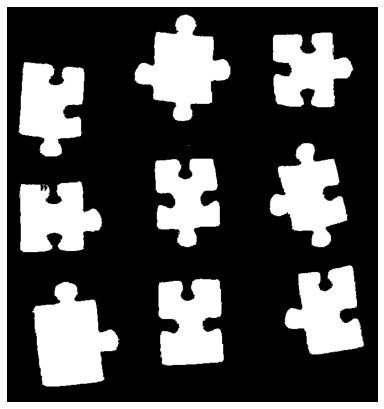

In [6]:
puzzle = np.array(Image.open('imgs/test2.png').convert('RGB'))
#showpic(puzzle)

# thresholding/binarization
thresh = cv2.cvtColor(puzzle, cv2.COLOR_RGBA2GRAY)
thresh = my_contrast_stretch(thresh)
thresh = thresh <= thresh.mean()
#showpic(thresh)


# find contours
thresh = cv2.cvtColor(puzzle, cv2.COLOR_RGBA2GRAY)
ret2,th3 = cv2.threshold(thresh,220,255,cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(th3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

h, w = th3.shape[:2]
vis = np.zeros((h, w, 3), np.uint8)
cv2.drawContours(vis, contours, -1, (255,255,255), -1)
showpic(vis)

In [7]:
# split image in tiles representing 1 piece each
tiles = []
for i in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i]) 
    
    # avoid noise
    if w < 10 and h < 10:
        continue
    
    shape, tile = np.zeros(thresh.shape[:2]), np.zeros((300,300), 'uint8') 
    cv2.drawContours(shape, [contours[i]], -1, color=1, thickness=-1)
    
    shape = (vis[:,:,1] * shape[:,:])[y:y+h, x:x+w] 
    tile[(300-h)//2 : (300-h)//2+h , (300-w)//2 : (300-w)//2+w] = shape  
    tiles.append(tile) 

In [8]:
def cart2pol(x, y):
    """cartesian to polar coordinates"""
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return rho, phi

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

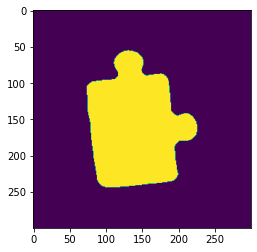

knobs: 2, holes: 0
Corner piece


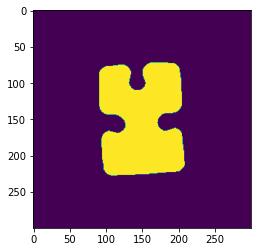

knobs: 0, holes: 3
Border piece


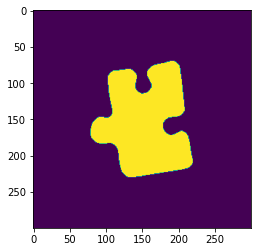

knobs: 2, holes: 2
Central piece


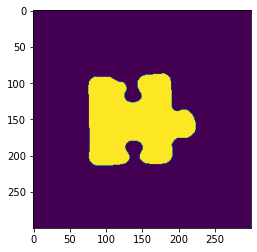

knobs: 1, holes: 2
Border piece


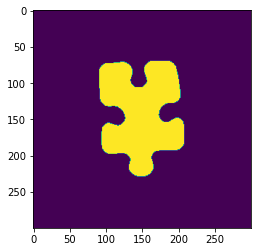

knobs: 1, holes: 3
Central piece


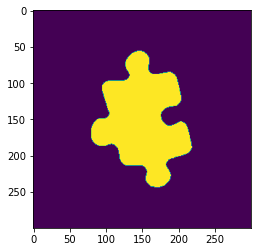

knobs: 3, holes: 1
Central piece


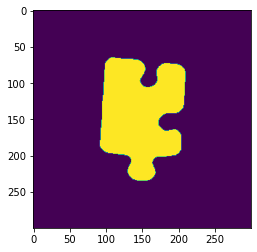

knobs: 1, holes: 2
Border piece


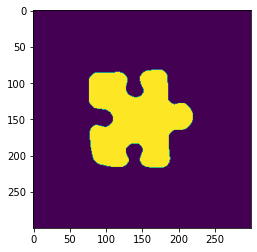

knobs: 1, holes: 3
Central piece


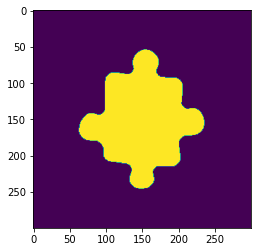

knobs: 4, holes: 0
Central piece


In [9]:
for puzzle_piece in tiles:
    img = puzzle_piece.copy()
    img = filters.median_filter(img.astype('uint8'), size=15)
    plt.imshow(img)
    plt.show()

    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    (center_x, center_y), _ = cv2.minEnclosingCircle(contours[0])

    # get contour points in polar coordinates
    rhos = []
    for i in range(len(contours[0])):
        x, y = contours[0][i][0]
        rho, _ = cart2pol(x - center_x, y - center_y)
        rhos.append(rho)

    rhos = smooth(rhos, 7) # adjust the smoothing amount if necessary
    
    # compute number of "knobs"
    n_knobs = len(find_peaks(rhos, height=0)[0]) - 4
    # adjust those cases where the peak is at the borders
    if rhos[-1] >= rhos[-2] and rhos[0] >= rhos[1]:
        n_knobs += 1
    
    # compute number of "holes"
    rhos[rhos >= 50] = rhos.max()
    rhos = 0 - rhos + abs(rhos.min())
    n_holes = len(find_peaks(rhos)[0])
    
    print(f"knobs: {n_knobs}, holes: {n_holes}")
    
    # classify piece
    n_features = n_knobs + n_holes
    if n_features > 4 or n_features < 0:
        print("ERROR")
    if n_features == 4:
        print("Central piece")
    if n_features == 3:
        print("Border piece")
    if n_features == 2:
        print("Corner piece")